In [3]:
import tensorflow as tf, albumentations as A
import numpy as np
import os, shutil, random, cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, copy
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import glob
%matplotlib inline

cudnn.benchmark = True
SEED = 0

def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

{'Train': 47961, 'Valid': 5836, 'Test': 5996}
{'Train': 2998, 'Valid': 730, 'Test': 750}


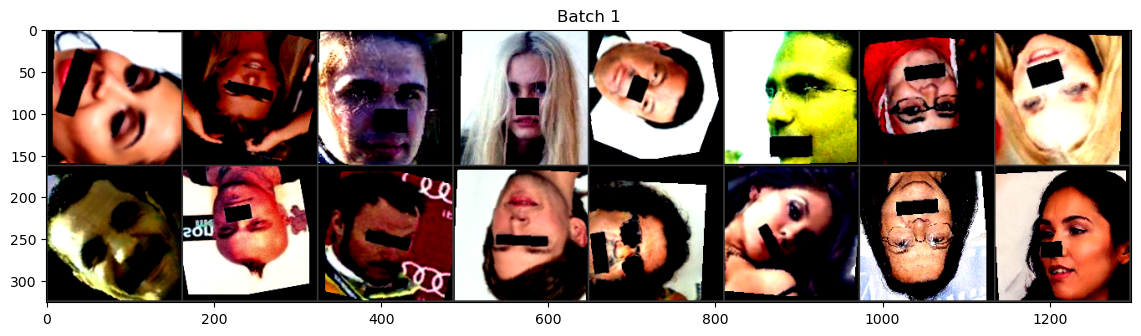

In [4]:
train_transform = transforms.Compose([
            # transforms.RandomRotation(30),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(0.25),
            transforms.Resize(160),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.25),
            transforms.RandomCrop(160, padding=10),
            # transforms.RandomAffine(5, shear=3, scale=(0.7, 0.95)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225]),
            ])

testandvalid_transform = transforms.Compose([
            # 
            
            transforms.Resize((160, 160)),
            # transforms.CenterCrop(130),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225]),
            ])

class CustomDataSet(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.data = self.create_data()
        self.class_map = {"Real" : 0, "Deepfake": 1}
        self.image_transform = transform
            
    def create_data(self):
        data = []
        file_list = glob.glob(self.root + "*")
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "\\*.jpg"):
                data.append([img_path, class_name])
        return np.array(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_loc, class_name = self.data[idx]
        image = Image.open(img_loc).convert('RGB')
        class_id = self.class_map[class_name]
        if self.image_transform:
            tensor_image = self.image_transform(image)
        return tensor_image, class_id

def create_dataloader(folder, transform, batch_size=64, train=False):
    if train:
        shuffle=True
    else:
        shuffle=False
    seed_everything()
    dataset = CustomDataSet(folder, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

Train = 'Data\\Train\\'
Valid = 'Data\\Validation\\'
Test = 'Data\\Test\\'
train_dataloader = create_dataloader(Train, train_transform, batch_size=16, train=True)
valid_dataloader = create_dataloader(Valid, testandvalid_transform, batch_size=8)
test_dataloader = create_dataloader(Test, testandvalid_transform, batch_size=8)
dataset_sizes = {'Train': len(train_dataloader.dataset),
                 'Valid': len(valid_dataloader.dataset),
                 'Test': len(test_dataloader.dataset)}

dataloader_sizes = {'Train': len(train_dataloader),
                 'Valid': len(valid_dataloader),
                 'Test': len(test_dataloader)}
dataloader_dict = {'Train': train_dataloader, 
                   'Valid': valid_dataloader,
                   'Test': test_dataloader}
print(dataset_sizes)
print(dataloader_sizes)

def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
#show sample batch of images
images, labels = next(iter(dataloader_dict['Train']))
out = torchvision.utils.make_grid(images)
imshow(out, 'Batch 1')

In [5]:
from collections import OrderedDict
import gc
def report_gpu():
   gc.collect()
   torch.cuda.empty_cache()


# Number of classes in the dataset
num_classes = 2
feature_extract = True
EPOCHS = 50

def get_model(modelname=None, feature_extract = True):
    print(modelname)
    if modelname == 'VGG19':
        print("models.VGG19BN")
        model = models.vgg19_bn(weights=models.VGG19_BN_Weights)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        # Pooling = nn.AdaptiveAvgPool2d(output_size=(5, 5))
        # model.avgpool = Pooling
        Classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(25088, 2048)),
                                ('relu', nn.ReLU()),
                                ('dropout', nn.Dropout(p=0.4)),
                                ('fc2', nn.Linear(2048, num_classes)),
                                ]))
        model.classifier = Classifier

    elif modelname == 'VGG16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False    
        model2 = model.features
        classifier = nn.Sequential(
                        nn.Linear(25088, 12800), nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(12800, 1024), nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(1024, 2),
                        )
        top_m = nn.Sequential()
        top_m.add_module('features', model2)
        top_m.add_module('flatten', nn.Flatten())
        top_m.add_module('classifier', classifier)
        model = top_m
    elif modelname == 'resnet50':
        print("models.resnet50")
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        model.fc  = nn.Sequential(
                        nn.Linear(2048, 128),
                        nn.ReLU(inplace=True),
                        nn.Linear(128, num_classes)).to(device)
    elif modelname == 'resnet101':
        print("models.resnet101")
        model = models.resnet101(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    elif modelname == 'resnet152':
        print("models.resnet152")
        model = models.resnet152(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    else:
        print('Effnet_b7')
        model = models.efficientnet_b7(pretrained=True)
        for param in model.parameters():
            if feature_extract:
                param.requires_grad = False
        # Classifier = nn.Sequential(OrderedDict([
        #                     # ('dropout', nn.Dropout(p=0.5, inplace=True)),
        #                     ('fc1', nn.Linear(2560, 1024)),
        #                     ('relu', nn.ReLU()),
        #                     # ('dropout', nn.Dropout(p=0.5, inplace=True)),
        #                     ('fc2', nn.Linear(1024, num_classes)),
        #                     ]))
        Classifier = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        model.classifier[1] = Classifier
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    # START_LR = 1e-7
    optimizer_conv = optim.Adam(params_to_update, lr = 1e-3)
    # optimizer_conv = optim.Adam([
    #             {'params':  model.features.parameters()},
    #             {'params': params_to_update, 'lr': 1e-3}
    #         ], lr=1e-2)
    criterion_conv = nn.CrossEntropyLoss()
    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer_conv, gamma=0.9)
    scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer_conv, milestones=[10,80], gamma=0.1)
    # exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    return model.to(device), criterion_conv.to(device), optimizer_conv, scheduler1, scheduler2

report_gpu()
model, loss_fn, optimizer, scheduler1, scheduler2 = get_model('VGG19')

VGG19
models.VGG19BN


c:\Users\abdel\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 classifier.fc1.weight
	 classifier.fc1.bias
	 classifier.fc2.weight
	 classifier.fc2.bias


In [17]:
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)
        for iteration in range(num_iter):
            loss = self._train_batch(iterator)
            lrs.append(lr_scheduler.get_last_lr()[0])
            # update lr
            lr_scheduler.step()
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
        return lrs, losses

    def _train_batch(self, iterator):
        self.model.train()
        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = self.model(x)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in
                self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)
    
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, loss_fn, device)
lrs, losses = lr_finder.range_test(dataloader_dict['Train'], END_LR, NUM_ITER)

Stopping early, the loss has diverged


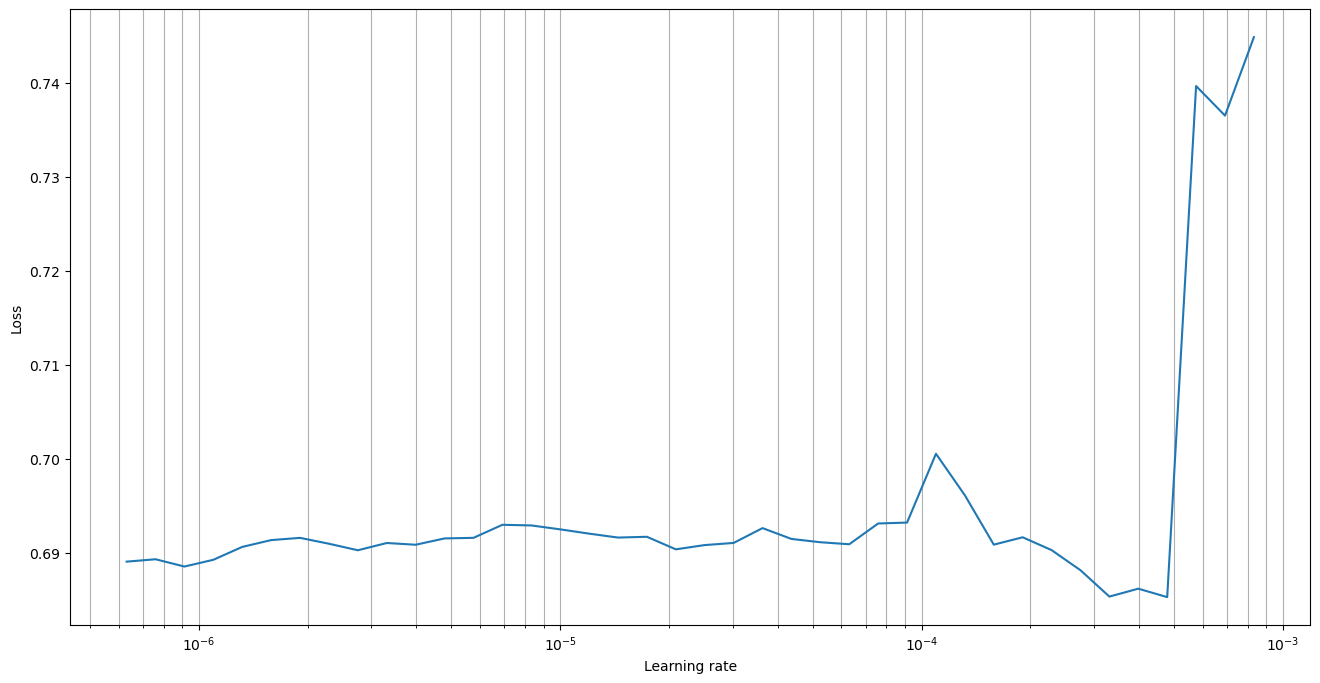

In [19]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()
plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

In [26]:
FOUND_LR = 7e-3
params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]
new_optimizer = optim.Adam(params, lr=FOUND_LR)

In [23]:
from tqdm import tqdm, trange

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    print("Training model")
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    print("Evaluating model")
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
EPOCHS = 15
best_valid_loss = float('inf')
for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, dataloader_dict['Train'], new_optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, dataloader_dict['Valid'], loss_fn, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   7%|▋         | 1/15 [05:42<1:19:57, 342.68s/it]

Epoch: 01 | Epoch Time: 5m 42s
	Train Loss: 0.908 | Train Acc: 52.79%
	 Val. Loss: 0.694 |  Val. Acc: 51.47%


Epochs:  13%|█▎        | 2/15 [11:24<1:14:10, 342.32s/it]

Epoch: 02 | Epoch Time: 5m 42s
	Train Loss: 0.699 | Train Acc: 49.89%
	 Val. Loss: 0.695 |  Val. Acc: 48.56%


Epochs:  20%|██        | 3/15 [17:09<1:08:41, 343.47s/it]

Epoch: 03 | Epoch Time: 5m 44s
	Train Loss: 0.696 | Train Acc: 50.05%
	 Val. Loss: 0.693 |  Val. Acc: 51.44%


Epochs:  20%|██        | 3/15 [19:49<1:19:17, 396.48s/it]


KeyboardInterrupt: 

In [7]:
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
from pytorchtools import EarlyStopping

def train_model(model, dataloaders, criterion, optimizer, scheduler1, scheduler2, num_epochs=EPOCHS):
    seed_everything()
    print(model._get_name())
    since = time.time()
    valid_acc_history, valid_loss_history = [], []
    train_acc_history, train_loss_history = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=20, verbose=True)
    for epoch in range(num_epochs):
        targets, ops = [], []
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--' * 50)
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()
            else:
                model.eval() 
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                targets.append(labels.detach().cpu().numpy())
                ops.append(preds.detach().cpu().numpy())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler1.step()
                scheduler2.step()
            ops_array = np.concatenate(ops)
            targets_array = np.concatenate(targets)
            f1 = f1_score(ops_array, targets_array)
            ps = precision_score(ops_array, targets_array)
            rc = recall_score(ops_array, targets_array)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f} F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}'.format(phase, epoch_loss, epoch_acc, f1, ps, rc))
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'Valid':
                valid_acc_history.append(epoch_acc)
                valid_loss_history.append(epoch_loss)
                early_stopping(np.average(epoch_loss), model)

            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
           
        print('Epoch completed in {:.0f}m {:.0f}s'.format((time.time()-start_epoch) // 60, (time.time()-start_epoch) % 60))
        if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Valid Acc: {:4f}'.format(best_acc))
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.load_state_dict(best_model_wts)
    return model, (train_acc_history, valid_acc_history), (train_loss_history, valid_loss_history)

report_gpu()
model_ft, acc_hist, loss_hist = train_model(model, dataloader_dict, loss_fn, optimizer, scheduler1, scheduler2, EPOCHS)

VGG
Epoch 1/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:58<00:00, 10.05it/s]


Train Loss: 0.6199 Acc: 0.6774 F1-score: 0.6777, Precision: 0.6789, Recall: 0.6765


100%|██████████| 730/730 [00:30<00:00, 23.85it/s]


Valid Loss: 0.5404 Acc: 0.7217 F1-score: 0.6833, Precision: 0.6883, Recall: 0.6784
Validation loss decreased (inf --> 0.540410).  Saving model ...
Epoch completed in 5m 30s

Epoch 2/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:57<00:00, 10.08it/s]


Train Loss: 0.5454 Acc: 0.7185 F1-score: 0.7151, Precision: 0.7071, Recall: 0.7232


100%|██████████| 730/730 [00:29<00:00, 24.58it/s]


Valid Loss: 0.5207 Acc: 0.7375 F1-score: 0.7137, Precision: 0.6994, Recall: 0.7286
Validation loss decreased (0.540410 --> 0.520715).  Saving model ...
Epoch completed in 5m 28s

Epoch 3/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:55<00:00, 10.16it/s]


Train Loss: 0.5175 Acc: 0.7408 F1-score: 0.7338, Precision: 0.7150, Recall: 0.7535


100%|██████████| 730/730 [00:29<00:00, 24.63it/s]


Valid Loss: 0.5141 Acc: 0.7473 F1-score: 0.7310, Precision: 0.7052, Recall: 0.7588
Validation loss decreased (0.520715 --> 0.514117).  Saving model ...
Epoch completed in 5m 26s

Epoch 4/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:09<00:00,  9.70it/s]


Train Loss: 0.5034 Acc: 0.7510 F1-score: 0.7437, Precision: 0.7231, Recall: 0.7656


100%|██████████| 730/730 [00:30<00:00, 24.22it/s]


Valid Loss: 0.4970 Acc: 0.7531 F1-score: 0.7411, Precision: 0.7147, Recall: 0.7695
Validation loss decreased (0.514117 --> 0.497008).  Saving model ...
Epoch completed in 5m 40s

Epoch 5/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:58<00:00, 10.03it/s]


Train Loss: 0.4894 Acc: 0.7591 F1-score: 0.7525, Precision: 0.7329, Recall: 0.7731


100%|██████████| 730/730 [00:29<00:00, 24.52it/s]


Valid Loss: 0.4780 Acc: 0.7706 F1-score: 0.7519, Precision: 0.7289, Recall: 0.7763
Validation loss decreased (0.497008 --> 0.477963).  Saving model ...
Epoch completed in 5m 29s

Epoch 6/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:56<00:00, 10.12it/s]


Train Loss: 0.4768 Acc: 0.7668 F1-score: 0.7609, Precision: 0.7429, Recall: 0.7799


100%|██████████| 730/730 [00:30<00:00, 24.18it/s]


Valid Loss: 0.4969 Acc: 0.7707 F1-score: 0.7590, Precision: 0.7358, Recall: 0.7837
EarlyStopping counter: 1 out of 20
Epoch completed in 5m 26s

Epoch 7/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:03<00:00,  9.88it/s]


Train Loss: 0.4661 Acc: 0.7747 F1-score: 0.7703, Precision: 0.7559, Recall: 0.7852


100%|██████████| 730/730 [00:30<00:00, 24.00it/s]


Valid Loss: 0.4619 Acc: 0.7779 F1-score: 0.7684, Precision: 0.7489, Recall: 0.7889
Validation loss decreased (0.477963 --> 0.461863).  Saving model ...
Epoch completed in 5m 35s

Epoch 8/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:02<00:00,  9.91it/s]


Train Loss: 0.4563 Acc: 0.7817 F1-score: 0.7769, Precision: 0.7609, Recall: 0.7936


100%|██████████| 730/730 [00:30<00:00, 24.10it/s]


Valid Loss: 0.5343 Acc: 0.7690 F1-score: 0.7720, Precision: 0.7468, Recall: 0.7990
EarlyStopping counter: 1 out of 20
Epoch completed in 5m 33s

Epoch 9/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:03<00:00,  9.88it/s]


Train Loss: 0.4503 Acc: 0.7819 F1-score: 0.7769, Precision: 0.7601, Recall: 0.7944


100%|██████████| 730/730 [00:30<00:00, 23.79it/s]


Valid Loss: 0.4823 Acc: 0.7803 F1-score: 0.7741, Precision: 0.7508, Recall: 0.7988
EarlyStopping counter: 2 out of 20
Epoch completed in 5m 34s

Epoch 10/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:02<00:00,  9.90it/s]


Train Loss: 0.4464 Acc: 0.7873 F1-score: 0.7820, Precision: 0.7636, Recall: 0.8014


100%|██████████| 730/730 [00:30<00:00, 23.58it/s]


Valid Loss: 0.4975 Acc: 0.7714 F1-score: 0.7763, Precision: 0.7469, Recall: 0.8082
EarlyStopping counter: 3 out of 20
Epoch completed in 5m 34s

Epoch 11/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:00<00:00,  9.98it/s]


Train Loss: 0.4323 Acc: 0.7967 F1-score: 0.7914, Precision: 0.7718, Recall: 0.8119


100%|██████████| 730/730 [00:29<00:00, 24.44it/s]


Valid Loss: 0.4523 Acc: 0.7930 F1-score: 0.7890, Precision: 0.7647, Recall: 0.8149
Validation loss decreased (0.461863 --> 0.452309).  Saving model ...
Epoch completed in 5m 31s

Epoch 12/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:54<00:00, 10.18it/s]


Train Loss: 0.4281 Acc: 0.7969 F1-score: 0.7919, Precision: 0.7737, Recall: 0.8111


100%|██████████| 730/730 [00:29<00:00, 24.64it/s]


Valid Loss: 0.4529 Acc: 0.7939 F1-score: 0.7896, Precision: 0.7663, Recall: 0.8144
EarlyStopping counter: 1 out of 20
Epoch completed in 5m 24s

Epoch 13/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:57<00:00, 10.08it/s]


Train Loss: 0.4229 Acc: 0.8008 F1-score: 0.7963, Precision: 0.7794, Recall: 0.8139


100%|██████████| 730/730 [00:29<00:00, 24.46it/s]


Valid Loss: 0.4671 Acc: 0.7947 F1-score: 0.7936, Precision: 0.7715, Recall: 0.8170
EarlyStopping counter: 2 out of 20
Epoch completed in 5m 27s

Epoch 14/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:55<00:00, 10.13it/s]


Train Loss: 0.4248 Acc: 0.8015 F1-score: 0.7966, Precision: 0.7777, Recall: 0.8164


100%|██████████| 730/730 [00:29<00:00, 24.40it/s]


Valid Loss: 0.4559 Acc: 0.7922 F1-score: 0.7933, Precision: 0.7684, Recall: 0.8199
EarlyStopping counter: 3 out of 20
Epoch completed in 5m 26s

Epoch 15/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:01<00:00,  9.94it/s]


Train Loss: 0.4218 Acc: 0.8005 F1-score: 0.7961, Precision: 0.7797, Recall: 0.8133


100%|██████████| 730/730 [00:30<00:00, 23.95it/s]


Valid Loss: 0.4607 Acc: 0.7951 F1-score: 0.7935, Precision: 0.7715, Recall: 0.8167
EarlyStopping counter: 4 out of 20
Epoch completed in 5m 32s

Epoch 16/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:04<00:00,  9.85it/s]


Train Loss: 0.4229 Acc: 0.8002 F1-score: 0.7948, Precision: 0.7746, Recall: 0.8161


100%|██████████| 730/730 [00:30<00:00, 23.90it/s]


Valid Loss: 0.4631 Acc: 0.7918 F1-score: 0.7917, Precision: 0.7657, Recall: 0.8195
EarlyStopping counter: 5 out of 20
Epoch completed in 5m 35s

Epoch 17/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:03<00:00,  9.89it/s]


Train Loss: 0.4193 Acc: 0.8027 F1-score: 0.7979, Precision: 0.7795, Recall: 0.8172


100%|██████████| 730/730 [00:30<00:00, 23.98it/s]


Valid Loss: 0.4923 Acc: 0.7887 F1-score: 0.7941, Precision: 0.7696, Recall: 0.8202
EarlyStopping counter: 6 out of 20
Epoch completed in 5m 34s

Epoch 18/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:02<00:00,  9.92it/s]


Train Loss: 0.4215 Acc: 0.8025 F1-score: 0.7980, Precision: 0.7807, Recall: 0.8160


100%|██████████| 730/730 [00:29<00:00, 24.72it/s]


Valid Loss: 0.4619 Acc: 0.7927 F1-score: 0.7947, Precision: 0.7713, Recall: 0.8195
EarlyStopping counter: 7 out of 20
Epoch completed in 5m 32s

Epoch 19/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:56<00:00, 10.11it/s]


Train Loss: 0.4162 Acc: 0.8044 F1-score: 0.7999, Precision: 0.7825, Recall: 0.8180


100%|██████████| 730/730 [00:29<00:00, 24.44it/s]


Valid Loss: 0.4661 Acc: 0.7930 F1-score: 0.7968, Precision: 0.7747, Recall: 0.8201
EarlyStopping counter: 8 out of 20
Epoch completed in 5m 27s

Epoch 20/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:59<00:00, 10.01it/s]


Train Loss: 0.4175 Acc: 0.8040 F1-score: 0.7994, Precision: 0.7817, Recall: 0.8179


100%|██████████| 730/730 [00:30<00:00, 24.10it/s]


Valid Loss: 0.4830 Acc: 0.7899 F1-score: 0.7954, Precision: 0.7711, Recall: 0.8213
EarlyStopping counter: 9 out of 20
Epoch completed in 5m 30s

Epoch 21/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:59<00:00, 10.02it/s]


Train Loss: 0.4178 Acc: 0.8049 F1-score: 0.8000, Precision: 0.7812, Recall: 0.8198


100%|██████████| 730/730 [00:30<00:00, 23.56it/s]


Valid Loss: 0.4707 Acc: 0.7872 F1-score: 0.7957, Precision: 0.7700, Recall: 0.8231
EarlyStopping counter: 10 out of 20
Epoch completed in 5m 30s

Epoch 22/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:58<00:00, 10.05it/s]


Train Loss: 0.4153 Acc: 0.8035 F1-score: 0.7983, Precision: 0.7784, Recall: 0.8192


100%|██████████| 730/730 [00:29<00:00, 24.34it/s]


Valid Loss: 0.4644 Acc: 0.7908 F1-score: 0.7944, Precision: 0.7677, Recall: 0.8231
EarlyStopping counter: 11 out of 20
Epoch completed in 5m 28s

Epoch 23/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:57<00:00, 10.07it/s]


Train Loss: 0.4149 Acc: 0.8049 F1-score: 0.8001, Precision: 0.7814, Recall: 0.8197


100%|██████████| 730/730 [00:29<00:00, 24.67it/s]


Valid Loss: 0.4554 Acc: 0.7932 F1-score: 0.7965, Precision: 0.7717, Recall: 0.8230
EarlyStopping counter: 12 out of 20
Epoch completed in 5m 27s

Epoch 24/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:58<00:00, 10.04it/s]


Train Loss: 0.4157 Acc: 0.8056 F1-score: 0.8013, Precision: 0.7847, Recall: 0.8186


100%|██████████| 730/730 [00:29<00:00, 24.45it/s]


Valid Loss: 0.4791 Acc: 0.7892 F1-score: 0.7969, Precision: 0.7730, Recall: 0.8225
EarlyStopping counter: 13 out of 20
Epoch completed in 5m 28s

Epoch 25/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:06<00:00,  9.77it/s]


Train Loss: 0.4137 Acc: 0.8067 F1-score: 0.8022, Precision: 0.7845, Recall: 0.8207


100%|██████████| 730/730 [00:31<00:00, 23.46it/s]


Valid Loss: 0.4635 Acc: 0.7930 F1-score: 0.7982, Precision: 0.7735, Recall: 0.8245
EarlyStopping counter: 14 out of 20
Epoch completed in 5m 38s

Epoch 26/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:01<00:00,  9.94it/s]


Train Loss: 0.4172 Acc: 0.8057 F1-score: 0.8011, Precision: 0.7832, Recall: 0.8198


100%|██████████| 730/730 [00:31<00:00, 23.37it/s]


Valid Loss: 0.4589 Acc: 0.7934 F1-score: 0.7974, Precision: 0.7731, Recall: 0.8234
EarlyStopping counter: 15 out of 20
Epoch completed in 5m 33s

Epoch 27/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:02<00:00,  9.90it/s]


Train Loss: 0.4132 Acc: 0.8063 F1-score: 0.8020, Precision: 0.7852, Recall: 0.8196


100%|██████████| 730/730 [00:30<00:00, 23.84it/s]


Valid Loss: 0.4631 Acc: 0.7940 F1-score: 0.7984, Precision: 0.7755, Recall: 0.8228
EarlyStopping counter: 16 out of 20
Epoch completed in 5m 34s

Epoch 28/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [04:59<00:00, 10.02it/s]


Train Loss: 0.4153 Acc: 0.8028 F1-score: 0.7977, Precision: 0.7786, Recall: 0.8179


100%|██████████| 730/730 [00:30<00:00, 23.55it/s]


Valid Loss: 0.4672 Acc: 0.7920 F1-score: 0.7942, Precision: 0.7688, Recall: 0.8214
EarlyStopping counter: 17 out of 20
Epoch completed in 5m 30s

Epoch 29/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:05<00:00,  9.82it/s]


Train Loss: 0.4152 Acc: 0.8052 F1-score: 0.8003, Precision: 0.7812, Recall: 0.8203


100%|██████████| 730/730 [00:30<00:00, 23.97it/s]


Valid Loss: 0.4514 Acc: 0.7932 F1-score: 0.7966, Precision: 0.7712, Recall: 0.8238
Validation loss decreased (0.452309 --> 0.451365).  Saving model ...
Epoch completed in 5m 37s

Epoch 30/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:04<00:00,  9.83it/s]


Train Loss: 0.4117 Acc: 0.8095 F1-score: 0.8048, Precision: 0.7859, Recall: 0.8246


100%|██████████| 730/730 [00:29<00:00, 24.41it/s]


Valid Loss: 0.4621 Acc: 0.7925 F1-score: 0.8007, Precision: 0.7756, Recall: 0.8275
EarlyStopping counter: 1 out of 20
Epoch completed in 5m 35s

Epoch 31/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:03<00:00,  9.86it/s]


Train Loss: 0.4111 Acc: 0.8087 F1-score: 0.8044, Precision: 0.7876, Recall: 0.8220


100%|██████████| 730/730 [00:30<00:00, 23.70it/s]


Valid Loss: 0.4795 Acc: 0.7880 F1-score: 0.7998, Precision: 0.7761, Recall: 0.8249
EarlyStopping counter: 2 out of 20
Epoch completed in 5m 35s

Epoch 32/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:03<00:00,  9.87it/s]


Train Loss: 0.4121 Acc: 0.8056 F1-score: 0.8009, Precision: 0.7829, Recall: 0.8198


100%|██████████| 730/730 [00:31<00:00, 23.04it/s]


Valid Loss: 0.4892 Acc: 0.7891 F1-score: 0.7965, Precision: 0.7711, Recall: 0.8237
EarlyStopping counter: 3 out of 20
Epoch completed in 5m 35s

Epoch 33/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:00<00:00,  9.98it/s]


Train Loss: 0.4132 Acc: 0.8070 F1-score: 0.8024, Precision: 0.7844, Recall: 0.8212


100%|██████████| 730/730 [00:30<00:00, 23.58it/s]


Valid Loss: 0.4768 Acc: 0.7915 F1-score: 0.7984, Precision: 0.7739, Recall: 0.8245
EarlyStopping counter: 4 out of 20
Epoch completed in 5m 32s

Epoch 34/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:09<00:00,  9.68it/s]


Train Loss: 0.4109 Acc: 0.8089 F1-score: 0.8056, Precision: 0.7922, Recall: 0.8194


100%|██████████| 730/730 [00:31<00:00, 22.94it/s]


Valid Loss: 0.4710 Acc: 0.7930 F1-score: 0.8012, Precision: 0.7797, Recall: 0.8238
EarlyStopping counter: 5 out of 20
Epoch completed in 5m 42s

Epoch 35/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:20<00:00,  9.35it/s]


Train Loss: 0.4098 Acc: 0.8066 F1-score: 0.8024, Precision: 0.7860, Recall: 0.8196


100%|██████████| 730/730 [00:32<00:00, 22.66it/s]


Valid Loss: 0.4672 Acc: 0.7896 F1-score: 0.7983, Precision: 0.7755, Recall: 0.8224
EarlyStopping counter: 6 out of 20
Epoch completed in 5m 53s

Epoch 36/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:14<00:00,  9.53it/s]


Train Loss: 0.4134 Acc: 0.8075 F1-score: 0.8033, Precision: 0.7870, Recall: 0.8204


100%|██████████| 730/730 [00:30<00:00, 24.06it/s]


Valid Loss: 0.4662 Acc: 0.7910 F1-score: 0.7990, Precision: 0.7751, Recall: 0.8243
EarlyStopping counter: 7 out of 20
Epoch completed in 5m 45s

Epoch 37/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:10<00:00,  9.66it/s]


Train Loss: 0.4112 Acc: 0.8073 F1-score: 0.8025, Precision: 0.7835, Recall: 0.8224


100%|██████████| 730/730 [00:31<00:00, 23.49it/s]


Valid Loss: 0.4663 Acc: 0.7916 F1-score: 0.7982, Precision: 0.7717, Recall: 0.8266
EarlyStopping counter: 8 out of 20
Epoch completed in 5m 42s

Epoch 38/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:01<00:00,  9.93it/s]


Train Loss: 0.4140 Acc: 0.8075 F1-score: 0.8026, Precision: 0.7836, Recall: 0.8227


100%|██████████| 730/730 [00:30<00:00, 24.01it/s]


Valid Loss: 0.4789 Acc: 0.7935 F1-score: 0.7989, Precision: 0.7739, Recall: 0.8257
EarlyStopping counter: 9 out of 20
Epoch completed in 5m 32s

Epoch 39/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:08<00:00,  9.72it/s]


Train Loss: 0.4141 Acc: 0.8060 F1-score: 0.8011, Precision: 0.7822, Recall: 0.8210


100%|██████████| 730/730 [00:32<00:00, 22.81it/s]


Valid Loss: 0.4810 Acc: 0.7903 F1-score: 0.7968, Precision: 0.7706, Recall: 0.8249
EarlyStopping counter: 10 out of 20
Epoch completed in 5m 41s

Epoch 40/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:04<00:00,  9.85it/s]


Train Loss: 0.4135 Acc: 0.8080 F1-score: 0.8040, Precision: 0.7883, Recall: 0.8203


100%|██████████| 730/730 [00:29<00:00, 24.62it/s]


Valid Loss: 0.4657 Acc: 0.7915 F1-score: 0.7998, Precision: 0.7771, Recall: 0.8238
EarlyStopping counter: 11 out of 20
Epoch completed in 5m 34s

Epoch 41/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:03<00:00,  9.89it/s]


Train Loss: 0.4094 Acc: 0.8089 F1-score: 0.8044, Precision: 0.7867, Recall: 0.8230


100%|██████████| 730/730 [00:30<00:00, 24.33it/s]


Valid Loss: 0.4694 Acc: 0.7906 F1-score: 0.8000, Precision: 0.7752, Recall: 0.8264
EarlyStopping counter: 12 out of 20
Epoch completed in 5m 33s

Epoch 42/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:01<00:00,  9.95it/s]


Train Loss: 0.4100 Acc: 0.8071 F1-score: 0.8024, Precision: 0.7839, Recall: 0.8218


100%|██████████| 730/730 [00:29<00:00, 24.35it/s]


Valid Loss: 0.4570 Acc: 0.7954 F1-score: 0.7990, Precision: 0.7746, Recall: 0.8249
EarlyStopping counter: 13 out of 20
Epoch completed in 5m 31s

Epoch 43/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:04<00:00,  9.85it/s]


Train Loss: 0.4121 Acc: 0.8082 F1-score: 0.8042, Precision: 0.7886, Recall: 0.8206


100%|██████████| 730/730 [00:29<00:00, 24.44it/s]


Valid Loss: 0.4606 Acc: 0.7918 F1-score: 0.7997, Precision: 0.7755, Recall: 0.8253
EarlyStopping counter: 14 out of 20
Epoch completed in 5m 34s

Epoch 44/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:01<00:00,  9.94it/s]


Train Loss: 0.4131 Acc: 0.8069 F1-score: 0.8025, Precision: 0.7852, Recall: 0.8206


100%|██████████| 730/730 [00:29<00:00, 24.47it/s]


Valid Loss: 0.4674 Acc: 0.7894 F1-score: 0.7979, Precision: 0.7728, Recall: 0.8247
EarlyStopping counter: 15 out of 20
Epoch completed in 5m 32s

Epoch 45/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:01<00:00,  9.93it/s]


Train Loss: 0.4107 Acc: 0.8087 F1-score: 0.8046, Precision: 0.7881, Recall: 0.8218


100%|██████████| 730/730 [00:31<00:00, 23.25it/s]


Valid Loss: 0.4619 Acc: 0.7896 F1-score: 0.7998, Precision: 0.7752, Recall: 0.8260
EarlyStopping counter: 16 out of 20
Epoch completed in 5m 34s

Epoch 46/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:00<00:00,  9.97it/s]


Train Loss: 0.4120 Acc: 0.8067 F1-score: 0.8022, Precision: 0.7848, Recall: 0.8204


100%|██████████| 730/730 [00:30<00:00, 23.93it/s]


Valid Loss: 0.4662 Acc: 0.7898 F1-score: 0.7979, Precision: 0.7733, Recall: 0.8241
EarlyStopping counter: 17 out of 20
Epoch completed in 5m 31s

Epoch 47/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:05<00:00,  9.82it/s]


Train Loss: 0.4129 Acc: 0.8044 F1-score: 0.8002, Precision: 0.7840, Recall: 0.8171


100%|██████████| 730/730 [00:30<00:00, 24.10it/s]


Valid Loss: 0.4596 Acc: 0.7937 F1-score: 0.7969, Precision: 0.7748, Recall: 0.8203
EarlyStopping counter: 18 out of 20
Epoch completed in 5m 36s

Epoch 48/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:04<00:00,  9.84it/s]


Train Loss: 0.4102 Acc: 0.8090 F1-score: 0.8044, Precision: 0.7864, Recall: 0.8233


100%|██████████| 730/730 [00:31<00:00, 22.96it/s]


Valid Loss: 0.4630 Acc: 0.7927 F1-score: 0.8004, Precision: 0.7759, Recall: 0.8264
EarlyStopping counter: 19 out of 20
Epoch completed in 5m 37s

Epoch 49/50
----------------------------------------------------------------------------------------------------


100%|██████████| 2998/2998 [05:00<00:00,  9.98it/s]


Train Loss: 0.4147 Acc: 0.8071 F1-score: 0.8031, Precision: 0.7873, Recall: 0.8196


100%|██████████| 730/730 [00:29<00:00, 24.36it/s]


Valid Loss: 0.4739 Acc: 0.7856 F1-score: 0.7979, Precision: 0.7734, Recall: 0.8240
EarlyStopping counter: 20 out of 20
Epoch completed in 5m 30s
We are at epoch: 48
Training complete in 272m 5s
Best Valid Acc: 0.795408


In [8]:
torch.save(model_ft.state_dict(), 'model.pt')

In [9]:
seed_everything()
test_dir = 'Test_Original\\test-task1\\'
test_dir_txt = 'Test_Original\\test-task1\\label-task1.txt'
test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160, 160)),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225]),
            ])

class TestDataSet(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.txt_root = os.path.join(self.root, 'label-task1.txt')
        self.data = self.create_data()
        self.image_transform = transform
            
    def create_data(self):
        # images = [], labels = []
        data = []
        with open(self.txt_root) as file:
            for line in file:
                image, class_id = line.rstrip() .split(" ")
                image = os.path.join(self.root, image)
                data.append([image, int(class_id)])
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_loc, class_id = self.data[idx]
        image = Image.open(img_loc).convert('RGB')
        if self.image_transform:
            tensor_image = self.image_transform(image)
        return tensor_image, class_id
    
def create_dataloader(folder, transform, batch_size=64):
    seed_everything()
    dataset = TestDataSet(folder, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

test_dataloader = create_dataloader(test_dir, test_transform, batch_size=16)
test_size = len(test_dataloader.dataset)
# model.load_state_dict(torch.load('model.pt'))
# model.to(device)

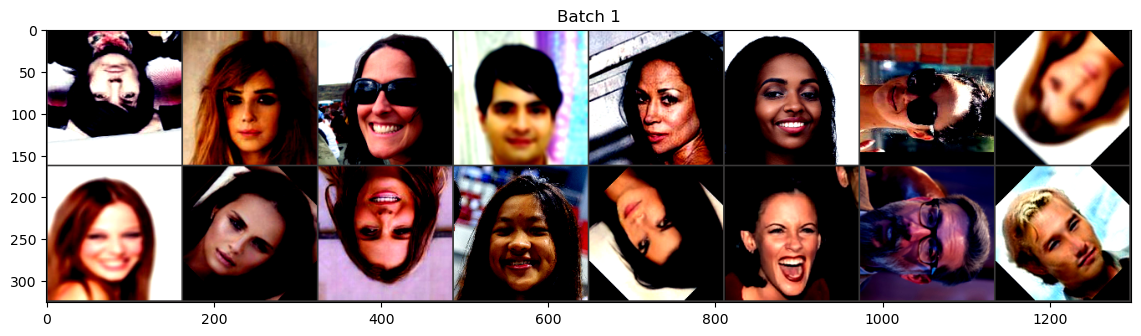

In [10]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
#show sample batch of images
images, labels = next(iter(test_dataloader))
out = torchvision.utils.make_grid(images)
imshow(out, 'Batch 1')

In [11]:
def evaluate(model, test_loader):
  with torch.no_grad():
      predictions = []
      values = []
      for input, label in tqdm(test_loader):
          input = input.to(device).float()
          label = torch.Tensor(label).view(len(label), -1)
          model.eval() # evaluation mode e.g. stop batchnorm, dropout
          yhat = model(input)
          _, y_pred = torch.max(yhat, 1)
          predictions.append(y_pred[0].cpu().detach().numpy()) #back to cpu to use numpy
          values.append(label[0].cpu().detach().numpy())

  return predictions, values

y_hat, y_true = evaluate(model, test_dataloader)

100%|██████████| 438/438 [01:20<00:00,  5.46it/s]


In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

acc = accuracy_score(y_true, y_hat)
print(acc)

0.6712328767123288


In [13]:

f1 = f1_score(y_true, y_hat)
f1

0.7428571428571429

In [14]:
confusion_matrix(y_true, y_hat)

array([[ 86,  32],
       [112, 208]], dtype=int64)

In [15]:
print(classification_report(y_true, y_hat))

              precision    recall  f1-score   support

           0       0.43      0.73      0.54       118
           1       0.87      0.65      0.74       320

    accuracy                           0.67       438
   macro avg       0.65      0.69      0.64       438
weighted avg       0.75      0.67      0.69       438

